In [68]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
from exploration.config import mongo_inst

In [69]:
MIN_ACC, PP_RANGE, PP_INTERVAL, MAX_PP = .9, 200, 100, 10000
INTERVALS = math.ceil((MAX_PP - PP_RANGE) / PP_INTERVAL)

osu_db = mongo_inst['osu_random_db']

In [70]:
bm_popularity_pipeline = [
    {
        '$group': {
            '_id': '$beatmap_id',
            'count': {
                '$sum': 1
            }
        }
    },
    {
        '$sort': {
            'count': -1
        }
    }
]

In [71]:
top_bm = list(osu_db['osu_scores_high'].aggregate(bm_popularity_pipeline))

In [72]:
def compute_acc(score):
    c50, c100, c300, cmiss = score['count50'], score['count100'], score['count300'], score['countmiss']
    return (c50 / 6 + c100 / 3 + c300) / (c50 + c100 + c300 + cmiss)

In [126]:
def criteria_curve(scores):
    est_pp = [s['mlpp']['est_user_pp'] for s in scores]
    acc = [compute_acc(s) for s in scores]

    criteria_pass = np.asarray(acc) > MIN_ACC
    cummulative_pass = np.cumsum(np.insert(criteria_pass, 0, False))

    total, n_pass = np.zeros(INTERVALS), np.zeros(INTERVALS)
    j_s, j_e = 0, 0

    for i in range(INTERVALS):
        b = i * PP_INTERVAL

        while j_s < len(est_pp) - 1 and est_pp[j_s] < b:
            j_s+=1
        
        while j_e < len(est_pp) - 1 and est_pp[j_e] < b + PP_RANGE:
            j_e+=1
        
        total[i] = j_e - j_s
        n_pass[i] = cummulative_pass[j_e] - cummulative_pass[j_s]
    
    return n_pass / total, total, n_pass

In [133]:
def insert_beatmap_reg(bm_id):
    scores_nm = list(
        osu_db['osu_scores_high'].find(
            {
                'beatmap_id': bm['_id'],
                'enabled_mods': 0
            },
            {
                'count50': 1,
                'count100': 1,
                'count300': 1,
                'countmiss': 1,
                'mlpp.est_user_pp': 1
            }
        ).sort('mlpp.est_user_pp')
    )
        
    scores_unfiltered = list(
        osu_db['osu_scores_high'].find(
            {
                'beatmap_id': bm['_id']
            },
            {
                'count50': 1,
                'count100': 1,
                'count300': 1,
                'countmiss': 1,
                'mlpp.est_user_pp': 1
            }
        ).sort('mlpp.est_user_pp')
    )

    _, total_nm, n_pass_nm = criteria_curve(scores_nm)
    _, total_unfiltered, n_pass_unfiltered = criteria_curve(scores_unfiltered)

    doc = {
        '_id': bm['_id'],
        'no_mod': {
            'total': total_nm.tolist(),
            'n_pass': n_pass_nm.tolist()
        },
        'all_scores': {
            'total': total_unfiltered.tolist(),
            'n_pass': n_pass_unfiltered.tolist()
        }
    }

    osu_db['beatmap_criteria_curve'].insert(doc)


In [134]:
for bm in tqdm(top_bm[:3000]):
    insert_beatmap_reg(bm['_id'])

100%|██████████| 3000/3000 [12:12<00:00,  4.10it/s]


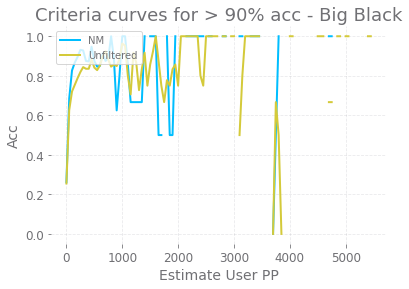

In [32]:
x = np.arange(0, INTERVALS) * PP_INTERVAL
plt.plot(x, criteria_curve(scores_nm)[0],  label = "NM")
plt.plot(x, criteria_curve(scores_unfiltered)[0], label = "Unfiltered")
plt.title("Criteria curves for > 90% acc - Big Black")
plt.xlabel("Estimate User PP")
plt.ylabel("Acc")
plt.legend(loc = "upper left")

In [55]:
total, n_pass = np.zeros(INTERVALS), np.zeros(INTERVALS)

for i in range(INTERVALS):
    b = i * PP_INTERVAL

    for j in range(len(est_pp)):
        if b < est_pp[j] < b + PP_RANGE:
            total[i] += 1
            n_pass[i] += criteria_pass[j]